# Heatwaves identification classification and visualisation with python

M.Y. Joshi<sup>1</sup>, D. Amaripadath<sup>2</sup>, A. Machard<sup>3,4</sup>, and S. Attia<sup>1</sup>

<sup>1</sup>Local Environment Management and Analysis (LEMA), Urban and Environmental Engineering Department, University of Liège, 4000 Liège, Belgium
<sup>2</sup>Sustainable Building Design Lab, Department of UEE, Faculty of Applied Sciences, University of Liege, 4000 Liege, Belgium          
<sup>3</sup>Centre Scientifique et Technique du Batiment (CSTB), Département Energie et Environnement, 24 Rue Joseph Fourier, 38400 Saint-Martin-d'Hères, France                          
<sup>4</sup>La Rochelle Université, Laboratoire des Sciences de l'Ingénieur pour l'Environnement (LASIE, UMR CNRMS 7356), 23 Avenue Albert Einstein, 17000 La Rochelle, France

This code can detect, classify, and visualize heatwaves considering the thresholds based on percentiles of daily mean temperature distribution over past years (Ouzeau et al., 2016). Here, we develop the code by Machard et al. (2022) further by introducing stripes visualising the average annual summer temperature. We also add a possibility for comparing heatwaves for two or more cities. Additionally, with this code, you can visualise and compare the intense heatwaves for the cities in a country/region on a map. The code is easy to use for beginners and professionals working with heatwaves. The code can directly produce graphs and information indicating the heatwaves and comparing it for two or more cities. 


References:

Ouzeau, G., et al. (2016). Heat waves analysis over France in present and future climate: Application of a new method on the EURO-CORDEX ensemble. Climate Services, 4, 1-12. 34 20.      
Machard, A.(2022). Assembling-future-weather-files-including-heatwaves: v1.0.0. Zenodo, doi: 10.5281/zenodo.7300024.



In [1]:
import pandas as pd
import numpy as np
import os
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
from matplotlib import rc
from matplotlib.font_manager import FontProperties
import matplotlib.lines as lines
from matplotlib.patches import Patch

#change the directory to the folder with data
os.chdir(r'/Users/mitali_ulg/OneDrive - Universite de Liege/Deepak_work/')

In [3]:
#The data is average daily mean temperature data for one or more cities
#column names are names of the cities
name = 'Weather_file.csv'  
df = pd.read_csv(name, index_col = 0)
df.index = pd.to_datetime(df.index)

df['year'] = df.index.year
df['month'] = df.index.month

df1 = df.loc[df['month'].isin([6,7,8])]

df_yearly = df1.groupby(['year']).mean()
df_yearly['year'] = df_yearly.index    

#define the period of studying heatwave, here, it is 2000 - 2020
first_year = 2000
last_year = 2020

cities = df_yearly.columns  #list of cities

In [6]:
#for analysing single city
city = 'Bruges'   
temp = df[city]

#for comparing more cities
n = 3 #number of cities
city_names = ['Liege', 'Brussels', 'Antwerp']   #replace with city names
for i in range(n):
    locals()[f'city{i+1}'] = city_names[i]
    locals()[f'temp{i+1}'] = df[locals()[f'city{i+1}']]

In [7]:
# Temperature thresholds to characterize heatwaves
#for single city
spic = temp.quantile(0.995)
sdeb = temp.quantile(0.975)
sint = temp.quantile(0.95)

#for comparing cities
for i in range(n):
    x = locals()[f'temp{i+1}']
    locals()[f'spic{i+1}'] = x.quantile(0.995)
    locals()[f'sdeb{i+1}'] = x.quantile(0.975)
    locals()[f'sint{i+1}'] = x.quantile(0.95)

In [8]:
# This function detects heatwaves over a 20 years dataset. 
# It returns a list of heatwaves, the heatwaves, a list of their severities a list of their duration, and a list of their Tmax

def get_dict_hws(daily_temp, spic, sdeb, sint):
    
    # Creating result, an empty dataframe with a series of 20 years daily temperatures
    result = pd.DataFrame({'Daily_Temp': daily_temp, 'sup_SPIC':"", '>SDEB':"", 'cons_SDEB':""})
    print(result)
    result['month']=result.index.month
    
    # Analysing only months from June to September included. !!! These must be replaced according to the summer period of the city of interest !!!
    filter_mask = (result['month'] > 5) & (result['month'] < 10)
    df = result[filter_mask]
    df.index = pd.to_datetime(df.index)
    del df['month']
    
    # Finding where the daily temperature exceeds the threshold SPIC
    df['sup_SPIC'] = np.where(df['Daily_Temp']>spic,df['Daily_Temp'],int(0))
    
    # Finding where the daily temperature exceeds the threshold SDEB
    df['>SDEB'] = np.where(df['Daily_Temp']>sdeb,df['Daily_Temp'],int(0))
    
    # Adding all the temperatures above the SDEB threshold to temp_sdeb
    temp_sdeb = df['>SDEB'].tolist()
    
    # Analyzing if temperatures are consecutive with a minimum of 3 days gap. If yes, filling the 'in between' days wit h1
    for i in range(0,len(temp_sdeb)-4):
    
        if ((temp_sdeb[i]!=0) and (temp_sdeb[i+4]!=0)):
            temp_sdeb[i+1]=1
            temp_sdeb[i+2]=1 
            temp_sdeb[i+3]=1
            
        if ((temp_sdeb[i]!=0) and (temp_sdeb[i+3]!=0)):
            temp_sdeb[i+1]=1
            temp_sdeb[i+2]=1 
            
        if ((temp_sdeb[i]!=0) and (temp_sdeb[i+2]!=0)):
            temp_sdeb[i+1]=1
            
    
    # Adding the list temp_sdeb to the dataframe column 'cons_SDEB'
    df['cons_SDEB'] = temp_sdeb
    
    # Replacing the 1 values with the temperature
    df['cons_SDEB'] = np.where(df['cons_SDEB']==1,df['Daily_Temp'],df['cons_SDEB'])
    
    # Filling with 0 if the heatwaves temperatures fall under the SINT threshold
    df['cons_SDEB'] = np.where(df['cons_SDEB']<sint,int(0),df['cons_SDEB'])
    
    # Keeping only the heatwaves temperatures where there is no 0
    df_reduit = df.loc[(df['cons_SDEB']!=0)]
    del df_reduit['Daily_Temp']
    del df_reduit['>SDEB']
    
    # Storing in hws a list of heatwaves (sorting through consecutive days)
    hws_idx = []
            
    for i in range(0, len(df_reduit)):
        if (df_reduit.index.dayofyear[i]-df_reduit.index.dayofyear[i-1])!=1:
            hws_idx.append(int(np.where(df_reduit.index==df_reduit.index[i])[0]))
    
    hws = []
    for i in range(0, len(hws_idx)-1):
        hws.append(df_reduit.iloc[hws_idx[i]:hws_idx[i+1]])
    
    for i in range(len(hws_idx)-1, len(hws_idx)):
        hws.append(df_reduit.iloc[hws_idx[i]:len(df_reduit)])
    
    ## Keeping in hws2 only the hws for which there is a temp > SPIC 
    hws2 = []
    for i in range(0, len(hws)):
        for a in range(0, len(hws[i])):
            if (hws[i]['sup_SPIC'][a]) > 1:
                hws2.append(hws[i])
                break
    
    ## Keeping in hws3 only the hws that are min 5 days long
    hws3 = []
    for i in range(0, len(hws2)):
        if len(hws2[i])>=5:
            hws3.append(hws2[i])
    
    # Calculating for each heatwave the severity and adding it to the list severities
    severities=[]
    for i in range(0, len(hws3)):
        b=0
        for j in range(0, len(hws3[i])):
            if (hws3[i]['cons_SDEB'][j])>sdeb:
                x = (hws3[i]['cons_SDEB'][j])-sdeb
                b=b+x
            
        severity=b/(spic-sdeb)
        severities.append(severity)
    
    # Calculating for each heatwave the length and adding it to the list lenghts
    lenghts=[]
    for i in range(0, len(hws3)):
        lenghts.append(len(hws3[i]))
    
    # Calculating for each heatwave the Tmax and adding it to the list maxs
    maxs=[]
    for i in range(0, len(hws3)):
        maxs.append(hws3[i]['sup_SPIC'].max())
    
    # Creating liste_hws, a list of lists containing all heatwaves characteristics
    liste_hws = [] 
    for (e, f, g, h) in zip(hws3, lenghts, maxs, severities): 
         liste_hws.append([e,f,g,h])

    return liste_hws, hws3, severities, lenghts, maxs

In [9]:
# Calling the function
#for single city
list_hws = get_dict_hws(temp, spic, sdeb, sint)

#for comparison
for i in range(n):
    t = locals()[f'temp{i+1}']
    s1 = locals()[f'spic{i+1}']
    s2 = locals()[f'sdeb{i+1}']
    s3 = locals()[f'sint{i+1}']
    locals()[f'list_hws{i+1}'] = get_dict_hws(t,s1,s2,s3)




            Daily_Temp sup_SPIC >SDEB cons_SDEB
2000-01-01        6.93                         
2000-01-02        7.93                         
2000-01-03        9.06                         
2000-01-04        7.63                         
2000-01-05        4.86                         
...                ...      ...   ...       ...
2020-12-27         NaN                         
2020-12-28         NaN                         
2020-12-29         NaN                         
2020-12-30         NaN                         
2020-12-31         NaN                         

[7671 rows x 4 columns]
            Daily_Temp sup_SPIC >SDEB cons_SDEB
2000-01-01        5.10                         
2000-01-02        5.71                         
2000-01-03        5.93                         
2000-01-04        6.74                         
2000-01-05        5.30                         
...                ...      ...   ...       ...
2020-12-27        3.43                         
2020-12-28     

/var/folders/p7/4l0vh4n17z99ld8s78gzxbz80000gn/T/ipykernel_10840/3828650040.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sup_SPIC'] = np.where(df['Daily_Temp']>spic,df['Daily_Temp'],int(0))
/var/folders/p7/4l0vh4n17z99ld8s78gzxbz80000gn/T/ipykernel_10840/3828650040.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['>SDEB'] = np.where(df['Daily_Temp']>sdeb,df['Daily_Temp'],int(0))
/var/folders/p7/4l0vh4n17z99ld8s78gzxbz80000gn/T/ipykernel_10840/3828650040.py:43: SettingWithCopyWarning: 
A v

In [10]:
list_hws

([[            sup_SPIC  cons_SDEB
   2002-08-15      0.00      22.06
   2002-08-16      0.00      20.86
   2002-08-17     23.52      23.52
   2002-08-18      0.00      22.15
   2002-08-19      0.00      20.92,
   5,
   23.52,
   2.858151023288623],
  [            sup_SPIC  cons_SDEB
   2003-08-04      0.00      21.88
   2003-08-05      0.00      22.43
   2003-08-06     24.95      24.95
   2003-08-07      0.00      21.31
   2003-08-08      0.00      18.88
   2003-08-09      0.00      19.72
   2003-08-10     24.36      24.36
   2003-08-11     25.50      25.50
   2003-08-12      0.00      21.47
   2003-08-13      0.00      20.53,
   10,
   25.5,
   6.887149547699972],
  [            sup_SPIC  cons_SDEB
   2004-08-02      0.00      20.31
   2004-08-03      0.00      21.58
   2004-08-04      0.00      20.43
   2004-08-05      0.00      21.36
   2004-08-06      0.00      19.94
   2004-08-07      0.00      19.87
   2004-08-08     24.14      24.14
   2004-08-09     24.46      24.46
   2004-08

In [11]:
#Normalising the temperatures for stripes visualisation

#for single city
#df_city = df_yearly[city]
df_yearly['norm'] = (df_yearly[city] - df_yearly[city].min())/(df_yearly[city].max() - df_yearly[city].min())
df_city = df_yearly['norm']

#for comparison
for i in range(n):
    x = locals()[f'city{i+1}']
    df_yearly['norm'] = (df_yearly[x] - df_yearly[x].min())/(df_yearly[x].max() - df_yearly[x].min())
    locals()[f'df_city{i+1}'] = df_yearly['norm']

# Visualisation 1: Heatwaves in relation to average annual summer temperature
It visualises: 
1. The heatwaves for the given period for a city  the warming stripes represents 
2. The annual average summer temperature of the city. 
3. The size of the circle represents the intensity of heatwave
4. The colour of the circles match the colour of the average summer temperature in that year, 
This makes it easier to understand the heatwaves in relation with average summer temperatures throughout the years


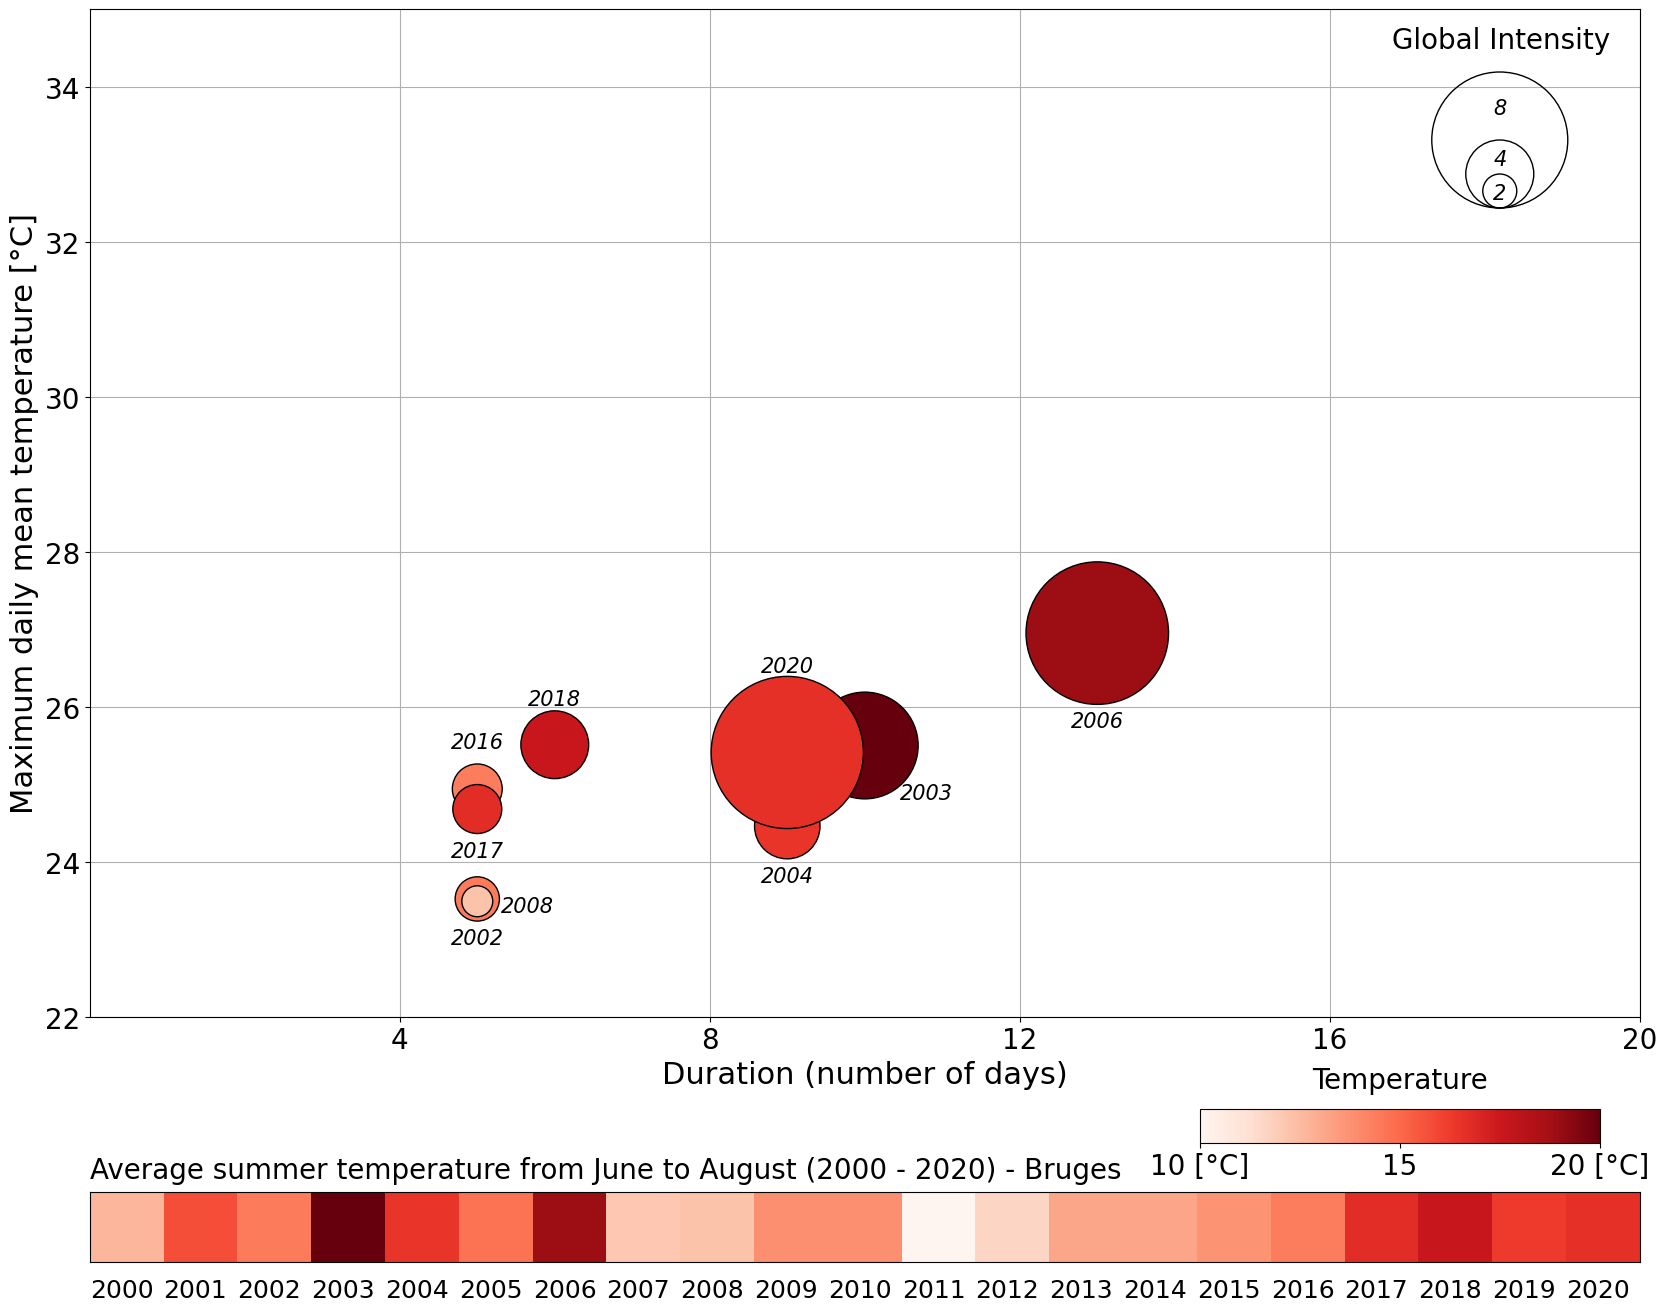

In [12]:
#sizing the figure, ax2 is the warming stripe, ax1 is the heatwave visualisation
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [16,1]}, figsize = (20,17))
plt.grid()

cmap = 'Reds'  #To change it to other colors, refer, https://matplotlib.org/stable/tutorials/colors/colormaps.html 

#warmingstripes
norm = plt.Normalize(0,1)
col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(first_year, last_year+1)   
])

col.set_array(df_city)
col.set_cmap(cmap)
col.set_clim(0,1)
col.set_norm(norm)

ax2.add_collection(col)
ax2.set_ylim(0, 1)
ax2.set_xlim(first_year, last_year+1)
ax2.set_yticks([])
ax2.set_xticks([])

for i in range(first_year, last_year+1):
    a = str(i)
    ax2.text(i,-0.5, a, fontsize=18, ha = 'left')
a = 'Average summer temperature from June to August (2000 - 2020) - ' + str(city)
ax2.text(2000,1.2, a, fontsize=20)    

#heatwave visualisation
years_hw = []

for i in range(len(list_hws[2])):
    heatwaves = list_hws[1]
    years = heatwaves[i].index.year[0]
    years_hw.append(years)

#c is colour code of year
c = []

for i in range(len(list_hws[2])):
    color_year = col.to_rgba(df_city.loc[years_hw[i]])
    c.append(color_year)

# Creating patches (circles)
patches = []

# For each heatwave:
# x is the lenght
# y is the tmax
# bubblesize is the severity

# Historical heatwaves
for i in range(0, len(list_hws[2])):
        fig_x = list_hws[3][i]
        fig_y = list_hws[4][i]
        fig_bubblesize = list_hws[2][i]/10
        circle_hist = Circle((fig_x, fig_y), fig_bubblesize, color= c[i])
        patches.append(circle_hist)



### PLOT  ####

p = PatchCollection(patches, match_original=True, edgecolor = 'black') 
ax1.grid()
ax1.set_axisbelow(True)
ax1.add_collection(p)
ax1.set_aspect('equal') ## keep the circles round
ax1.set_ylim(22,35)
ax1.set_xlim(0,20)
ax1.tick_params(labelsize = 20)
ax1.set_xticks([4, 8, 12, 16, 20])
ax1.set_xticklabels([4, 8, 12, 16, 20])
ax1.set_yticks([22, 24, 26, 28, 30, 32, 34])
ax1.set_yticklabels([22, 24, 26, 28, 30, 32, 34])
ax1.set_xlabel("Duration (number of days)", fontsize=22)
ax1.set_ylabel("Maximum daily mean temperature [°C]", fontsize=22)

#Label the years
for i in range(0, len(list_hws[3])):
        fig_x = list_hws[3][i] 
        fig_y = list_hws[4][i] - list_hws[2][i]/10 - 0.4
        ax1.annotate(years_hw[i], xy=(fig_x, fig_y), fontsize=15, ha = 'center', 
                     va = "bottom", style = 'italic')


#for the legend warming stripe
ax3 = plt.axes([0.68, 0.18, 0.2, 0.02])
ax3.set_yticks([])
ax3.set_xticks([])

cmap = 'Reds'
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax3, orientation='horizontal', ticks=[0, 0.5, 1])
cbar.ax.set_xticklabels(['10 [°C]','15', '20 [°C]'],  fontsize = 20)
cbar.ax.set_title('Temperature', fontsize=20, pad = 15)
plt.xticks()


#For severity legend
ax4 = plt.axes([0.78, 0.72, 0.1, 0.1])
circle1 = plt.Circle((0.5, 0.5), 0.4, edgecolor='black', fill = False)
circle2 = plt.Circle((0.5, 0.3), 0.2, edgecolor='black', fill = False)
circle3 = plt.Circle((0.5, 0.2), 0.1, edgecolor='black', fill = False)
ax4.add_patch(circle1)
ax4.add_patch(circle2)
ax4.add_patch(circle3)
ax4.set_aspect('equal')
line1 = lines.Line2D([0.5,0.96], [0.9, 0.9], color = 'black')
line2 = lines.Line2D([0.5,0.96], [0.5, 0.5], color = 'black')
line3 = lines.Line2D([0.5,0.96], [0.3, 0.3], color = 'black')

ax4.annotate('8', xy=(0.5,0.65), fontsize=15, ha = 'center', 
                      style = 'italic')
ax4.annotate('4', xy=(0.5,0.35), fontsize=15, ha = 'center', 
                      style = 'italic')
ax4.annotate('2', xy=(0.5,0.15), fontsize=15, ha = 'center', 
                      style = 'italic')
ax4.set_yticks([])
ax4.set_xticks([])
ax4.axis('off')
b = 'Global Intensity' 
ax1.text(16.8,34.5, b, fontsize=20)    


#save the plot as jpeg
plt.savefig(str(city) + '_heatwave.jpg')


# Visualisation 2: Comparing heatwaves for more than two cities
The visualisation compares the severity and occurrences of heatwaves for more than two cities

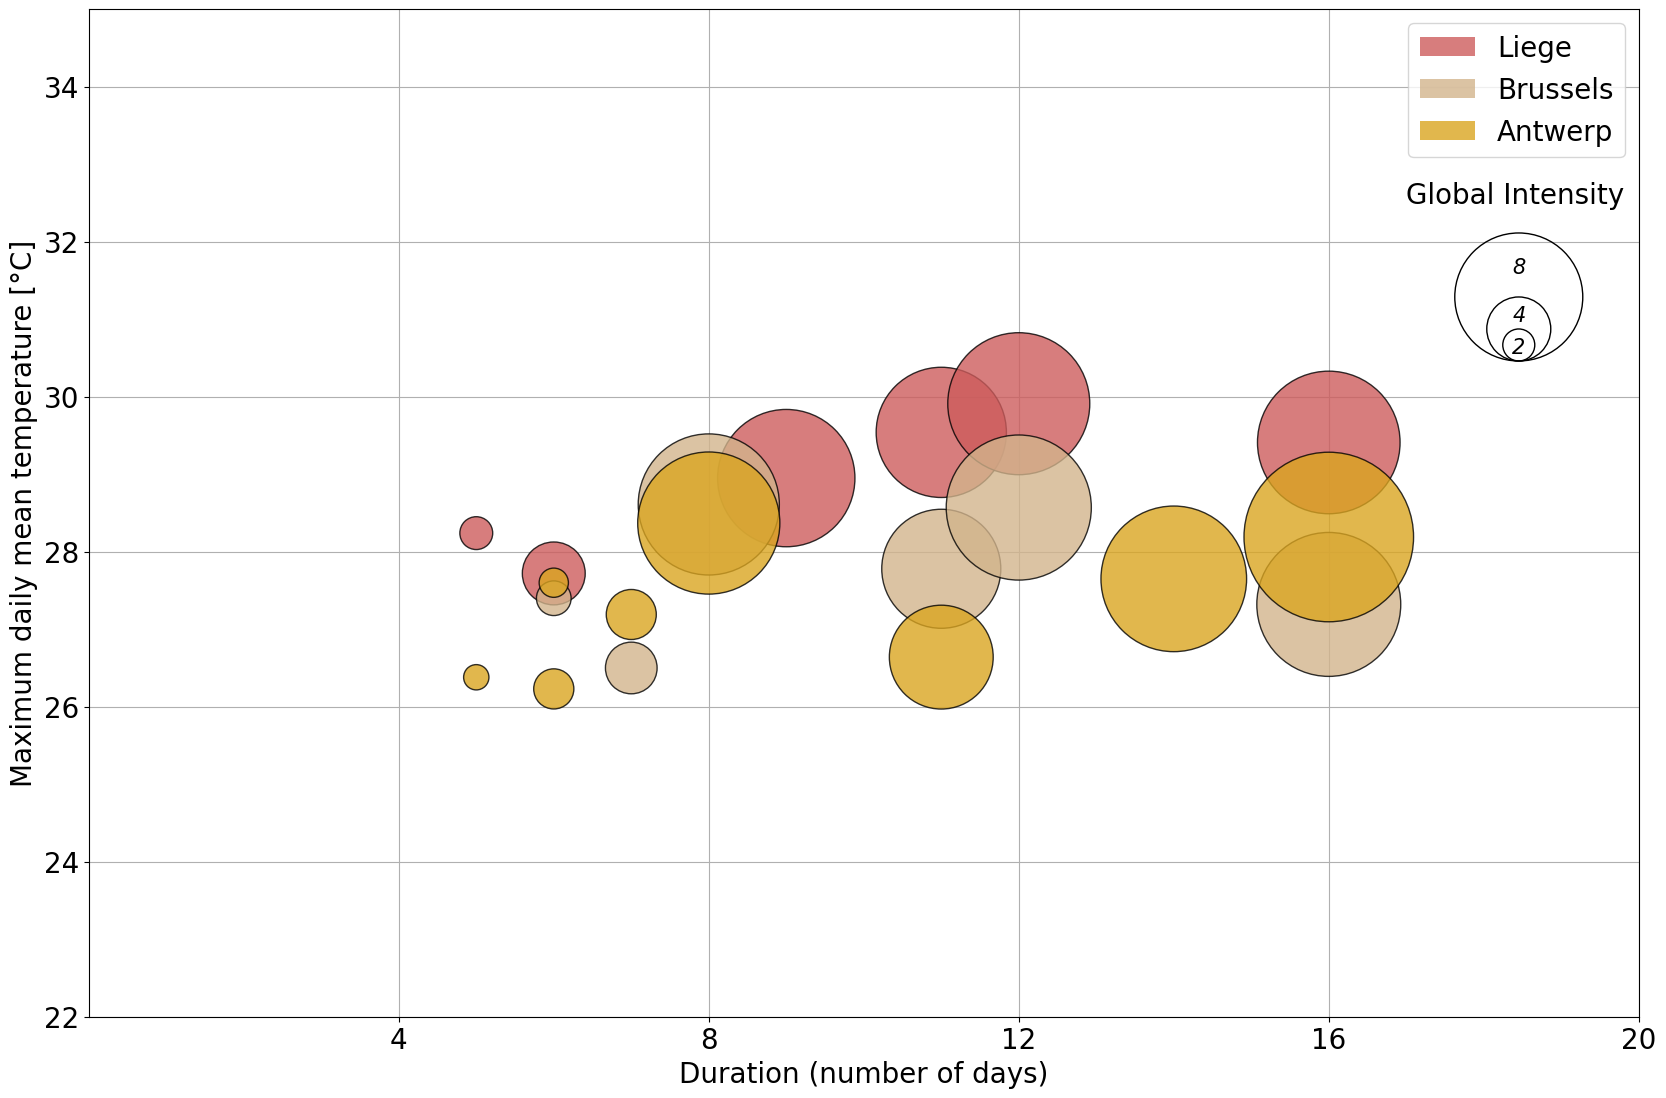

In [19]:
fig, ax1 = plt.subplots(figsize=(20, 16))

n = 3 #number of cities, change the number if more cities
for i in range(n):
    locals()[f'years_hw{i+1}'] = []
    x = locals()[f'years_hw{i+1}']
    y = locals()[f'list_hws{i+1}'] 
    for j in range(len(y[2])):
            heatwaves = y[1]
            years = heatwaves[j].index.year[0]
            x.append(years)


c = ['indianred', 'tan', 'goldenrod' ] #add more colors if more cities 
# link for colornames : https://matplotlib.org/stable/gallery/color/named_colors.html

for i in range(n):
    x = locals()[f'years_hw{i+1}']
    y = locals()[f'list_hws{i+1}']  
    locals()[f'circle_hist{i+1}'] = []
    circle_hist = locals()[f'circle_hist{i+1}'] 
    #c = locals()[f'c{i+1}']
    locals()[f'patches{i+1}'] = []
    patches = locals()[f'patches{i+1}']
    for j in range(0, len(y[2])):
        fig_x = y[3][j]
        #print(fig_x)
        fig_y = y[4][j]
        #print(fig_y)
        fig_bubblesize = y[2][j]/10
        #print(fig_bubblesize)
        circle_hist = Circle((fig_x, fig_y), fig_bubblesize, color = c[i])
        patches.append(circle_hist)


for i in range(n):
    patches = locals()[f'patches{i+1}']
    locals()[f'p{i+1}'] = PatchCollection(patches, match_original=True, edgecolor = 'black', alpha = 0.8)
    #p.set_alpha(0.5)

ax1.grid()
ax1.set_axisbelow(True)

for i in range(n):
    p = locals()[f'p{i+1}']
    ax1.add_collection(p)
    

ax1.set_aspect('equal') ## keep the circles round
ax1.set_ylim(22,35)
ax1.set_xlim(0,20)
#ax1.set_alpha(0.8)
ax1.tick_params(labelsize = 20)
ax1.set_xticks([4, 8, 12, 16, 20])
ax1.set_xticklabels([4, 8, 12, 16, 20])
ax1.set_yticks([22, 24, 26, 28, 30, 32, 34])
ax1.set_yticklabels([22, 24, 26, 28, 30, 32, 34])
ax1.set_xlabel("Duration (number of days)", fontsize=20)
ax1.set_ylabel("Maximum daily mean temperature [°C]", fontsize=20)

#legend for cities
patch1 = Patch(facecolor=c[0], label=city1, alpha = 0.8)
patch2 = Patch(facecolor=c[1], label=city1, alpha = 0.8)
patch3 = Patch(facecolor=c[2], label=city1, alpha = 0.8)
ax1.legend([patch1, patch2, patch3], [city1, city2, city3], fontsize=20, loc='upper right')


#For severity legend
ax4 = plt.axes([0.79, 0.58, 0.1, 0.1])
circle1 = plt.Circle((0.5, 0.5), 0.4, edgecolor='black', fill = False)
circle2 = plt.Circle((0.5, 0.3), 0.2, edgecolor='black', fill = False)
circle3 = plt.Circle((0.5, 0.2), 0.1, edgecolor='black', fill = False)
ax4.add_patch(circle1)
ax4.add_patch(circle2)
ax4.add_patch(circle3)
ax4.set_aspect('equal')
line1 = lines.Line2D([0.5,0.96], [0.9, 0.9], color = 'black')
line2 = lines.Line2D([0.5,0.96], [0.5, 0.5], color = 'black')
line3 = lines.Line2D([0.5,0.96], [0.3, 0.3], color = 'black')

ax4.annotate('8', xy=(0.5,0.65), fontsize=15, ha = 'center', 
                      style = 'italic')
ax4.annotate('4', xy=(0.5,0.35), fontsize=15, ha = 'center', 
                      style = 'italic')
ax4.annotate('2', xy=(0.5,0.15), fontsize=15, ha = 'center', 
                      style = 'italic')
ax4.set_yticks([])
ax4.set_xticks([])
ax4.axis('off')
b = 'Global Intensity' 
ax1.text(17,32.5, b, fontsize=20)    
  


plt.savefig('cities_comparison_heatwave.jpg')


# Visualisation 3: Comparing warming stripes of more cities
The warming stripes indicate the annual average summer temperatures for the given period. The visualisation helps in comparing more cities. 

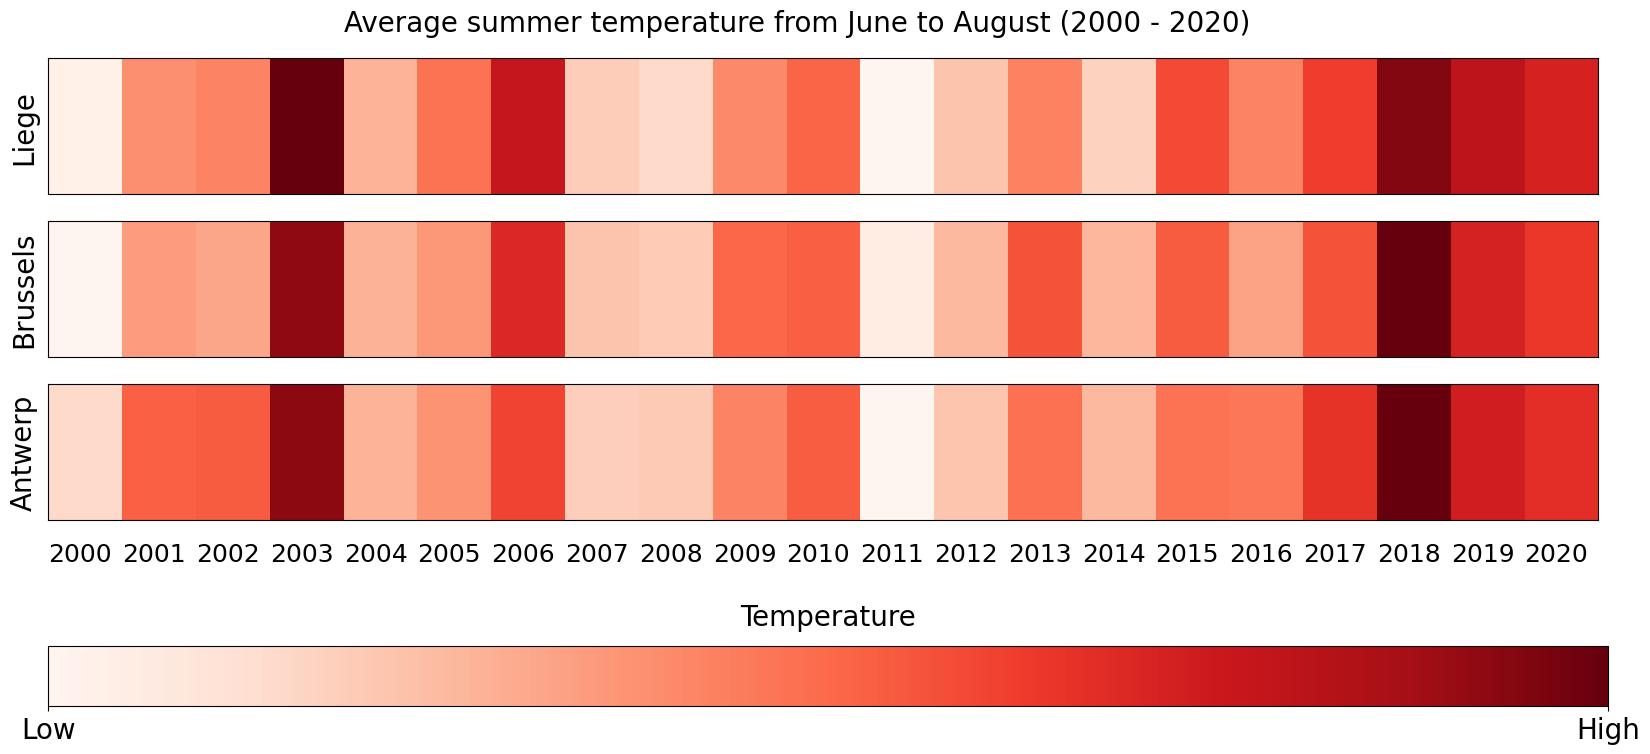

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1,1,1]}, figsize = (20,6))
plt.grid()
cmap = 'Reds'

#warmingstripes ax2
norm = plt.Normalize(0,1)
col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(first_year, last_year+1)
])

col.set_cmap(cmap)
col.set_clim(0,1)
col.set_norm(norm)
col.set_array(df_city1)


#print(reference - LIM, reference + LIM)
ax1.add_collection(col)
ax1.set_ylim(0, 1)
ax1.set_xlim(first_year, last_year+1)
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_ylabel('Liege', fontsize=20)

#warmingstripes ax2
norm = plt.Normalize(0,1)
col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(first_year, last_year+1)
])

col.set_array(df_city2)
col.set_cmap(cmap)
col.set_clim(0,1)
col.set_norm(norm)

#print(reference - LIM, reference + LIM)
ax2.add_collection(col)
ax2.set_ylim(0, 1)
ax2.set_xlim(2000, 2021)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_ylabel('Brussels', fontsize=20)


#warmingstripes ax2
norm = plt.Normalize(0,1)
col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(first_year, last_year+1)
])

col.set_array(df_city3)
col.set_cmap(cmap)
col.set_clim(0,1)
col.set_norm(norm)

#print(reference - LIM, reference + LIM)
ax3.add_collection(col)
ax3.set_ylim(0, 1)
ax3.set_xlim(2000, 2021)
ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_ylabel('Antwerp', fontsize=20)

for i in range(2000, 2021):
    a = str(i)
    ax3.text(i,-0.3, a, fontsize=18, ha = 'left')
a = 'Average summer temperature from June to August' + '('+ first_year + ' - ' + last_year + ')'   #Title of the plot
ax1.text(2004,1.2, a, fontsize=20) 

ax1 = plt.axes([0.125, -0.2, 0.78, 0.1])
ax1.set_yticks([])
ax1.set_xticks([])


cmap = 'Reds'
norm = mpl.colors.Normalize(vmin=0, vmax=1)


cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax1, orientation='horizontal', ticks=[0, 1])
cbar.ax.set_xticklabels(['Low', 'High'], fontsize = 20)
cbar.ax.set_title('Temperature', fontsize=20, pad = 15)
plt.xticks()

plt.savefig('Comparison_summer_temp.jpg')


# Visualisation 4: Mapping the severity 
Visualises the severity of various cities within a region spatially

In [15]:
#for comparing more cities
#extracting the severities
n = 6 #number of cities
city_names = ['Liege', 'Brussels', 'Antwerp', 'Ghent', 'Bruges', 'Charleroi']
for i in range(n):
    locals()[f'city{i+1}'] = city_names[i]
    locals()[f'temp{i+1}'] = df[locals()[f'city{i+1}']]

#for comparing cities
for i in range(n):
    x = locals()[f'temp{i+1}']
    locals()[f'spic{i+1}'] = x.quantile(0.995)
    locals()[f'sdeb{i+1}'] = x.quantile(0.975)
    locals()[f'sint{i+1}'] = x.quantile(0.95)
    
#for comparison
for i in range(n):
    t = locals()[f'temp{i+1}']
    s1 = locals()[f'spic{i+1}']
    s2 = locals()[f'sdeb{i+1}']
    s3 = locals()[f'sint{i+1}']
    locals()[f'list_hws{i+1}'] = get_dict_hws(t,s1,s2,s3)

severity = []
for i in range(6):
    x = max(locals()[f'list_hws{i+1}'][2])
    severity.append(x)

print(severity)



            Daily_Temp sup_SPIC >SDEB cons_SDEB
2000-01-01        5.10                         
2000-01-02        5.71                         
2000-01-03        5.93                         
2000-01-04        6.74                         
2000-01-05        5.30                         
...                ...      ...   ...       ...
2020-12-27        3.43                         
2020-12-28        2.46                         
2020-12-29        2.17                         
2020-12-30        2.95                         
2020-12-31        1.71                         

[7671 rows x 4 columns]
            Daily_Temp sup_SPIC >SDEB cons_SDEB
2000-01-01        6.18                         
2000-01-02        7.31                         
2000-01-03        7.38                         
2000-01-04        7.52                         
2000-01-05        4.92                         
...                ...      ...   ...       ...
2020-12-27        2.89                         
2020-12-28     

/var/folders/p7/4l0vh4n17z99ld8s78gzxbz80000gn/T/ipykernel_10840/3828650040.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sup_SPIC'] = np.where(df['Daily_Temp']>spic,df['Daily_Temp'],int(0))
/var/folders/p7/4l0vh4n17z99ld8s78gzxbz80000gn/T/ipykernel_10840/3828650040.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['>SDEB'] = np.where(df['Daily_Temp']>sdeb,df['Daily_Temp'],int(0))
/var/folders/p7/4l0vh4n17z99ld8s78gzxbz80000gn/T/ipykernel_10840/3828650040.py:43: SettingWithCopyWarning: 
A v

In [16]:
#year of heatwave
n = 6 #number of cities  
for i in range(n):
    locals()[f'years_hw{i+1}'] = []
    x = locals()[f'years_hw{i+1}']
    y = locals()[f'list_hws{i+1}'] 
    for j in range(len(y[2])):
            heatwaves = y[1]
            years = heatwaves[j].index.year[0]
            x.append(years)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarni

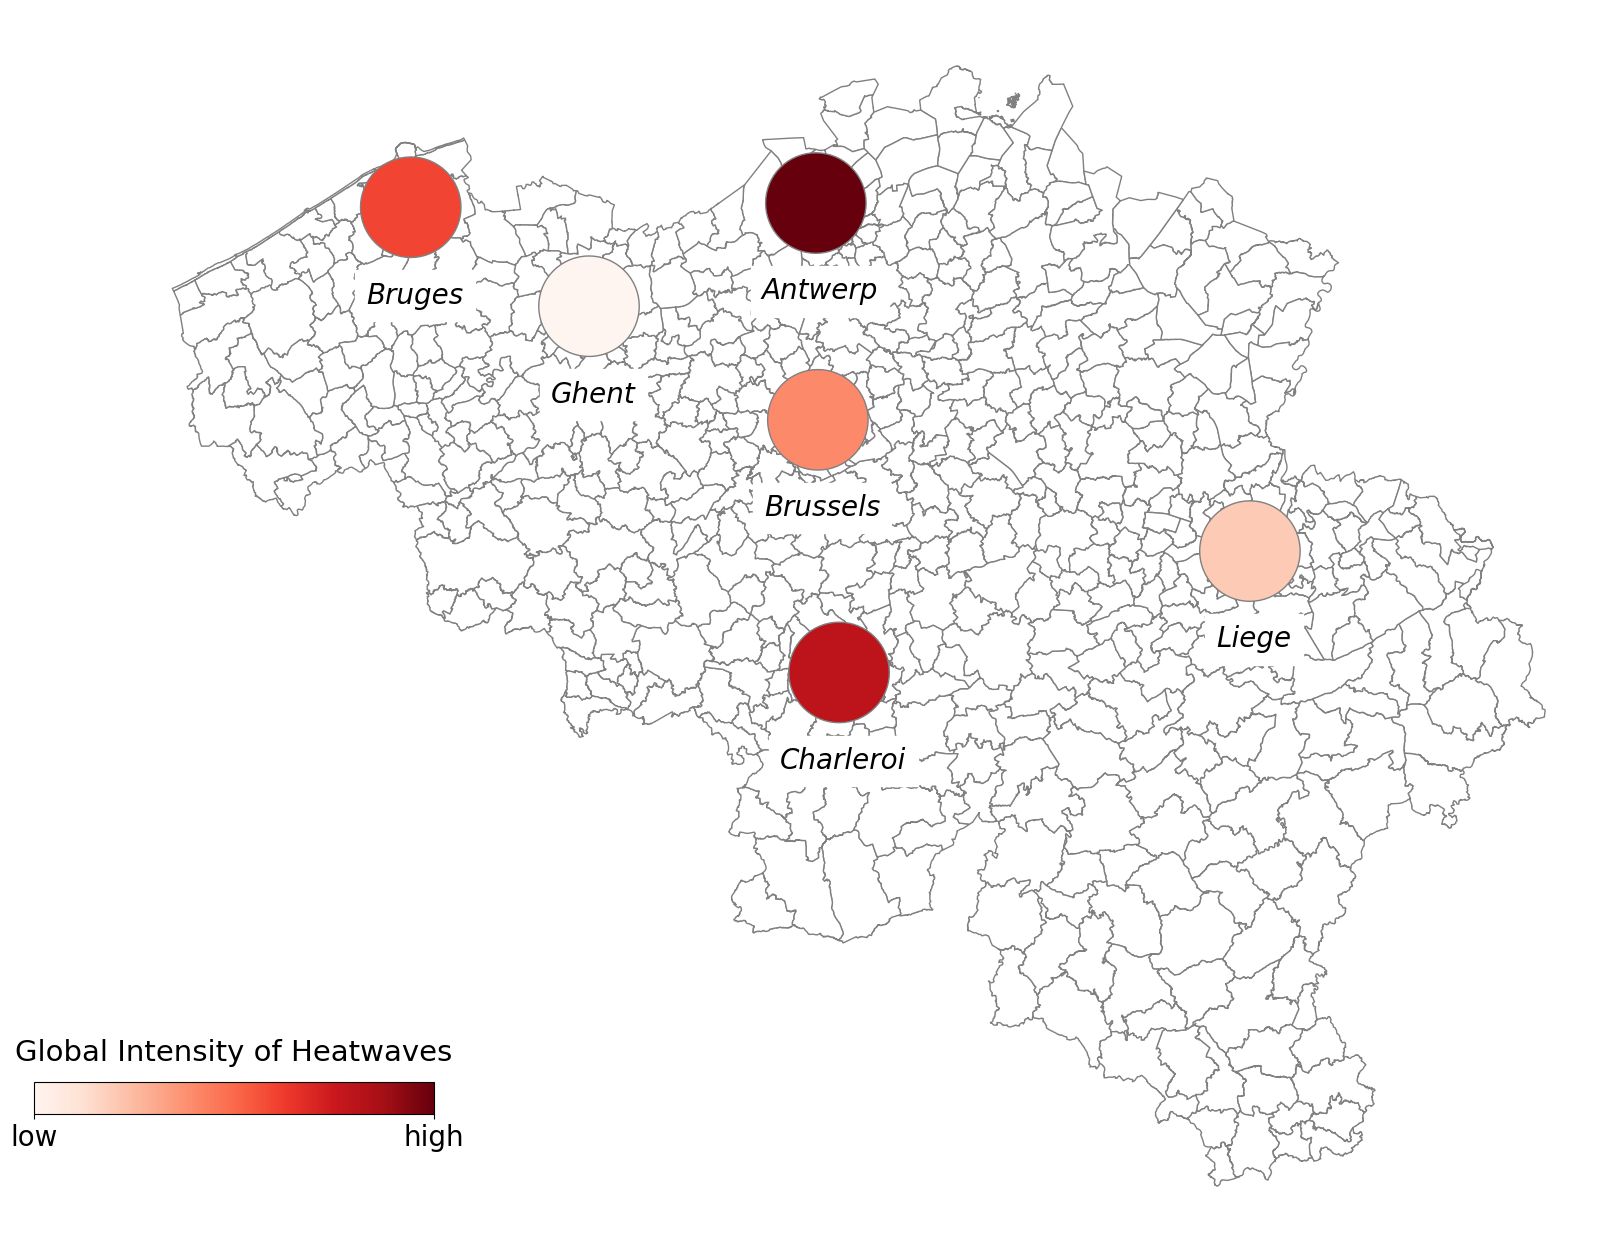

In [18]:
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar

Belg = gpd.read_file('Apn_AdMu.shp') #Shapefile of municipality or city boundaries

fig, ax = plt.subplots(figsize=(20, 16))
ax.set_aspect('equal')

Belg.plot(ax=ax, color='white', edgecolor='gray')

#Filtering the cities for study from all the cities in a region/country
Belg1 = Belg.loc[Belg.NameFRE.isin(['LIEGE', 'BRUXELLES', 'ANVERS', 'GAND', 'BRUGES', 'CHARLEROI'])  ]

x = ['LIEGE', 'BRUXELLES', 'ANVERS', 'GAND', 'BRUGES', 'CHARLEROI']
labels = ['Liege', 'Brussels', 'Antwerp', 'Ghent', 'Bruges', 'Charleroi']


Belg1['label'] = None
Belg1['Severity'] = None
for i in range(6):
    
     Belg1.loc[Belg1['NameFRE'] == x[i], 'labels'] = labels[i]
     Belg1.loc[Belg1['NameFRE'] == x[i], 'Severity'] = severity[i]

Belg1['sev_norm'] = (Belg1['Severity'] - Belg1['Severity'].min())/(Belg1['Severity'].max() - Belg1['Severity'].min())


Belg2 = Belg1.geometry.centroid
Belg3 = Belg2.geometry.buffer(10000)

Belg4 = Belg1.set_geometry(Belg3)

Belg4.plot(ax=ax, edgecolor='grey', column='sev_norm', cmap = 'Reds')
for x, y, label in zip(Belg2.geometry.x, Belg2.geometry.y, Belg1.labels):
    ax.annotate(label, xy=(x, y-20000), xytext=(3, 3), textcoords="offset points", ha = 'center', 
                 backgroundcolor="w", style = 'italic', fontsize = 20 )
    
ax1 = plt.axes([0.1, 0.19, 0.2, 0.02])
ax1.set_yticks([])
ax1.set_xticks([])

#colours comparing intense heatwaves
cmap = 'Reds'
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax1, orientation='horizontal', ticks=[0, 1])
cbar.ax.set_xticklabels(['low', 'high'], fontsize = 20)
cbar.ax.set_title('Global Intensity of Heatwaves', fontsize=21, pad = 15)
plt.xticks()

ax.set_axis_off()
plt.savefig('map_severity.jpg')


In [ ]:
#To save the details of heatwaves for all the cities 
n = 6 #number of cities
for i in range(n):
    locals()[f'hw{i+1}'] = pd.DataFrame(columns = ['sup_SPIC', 'cons_SDEB'])
    hw = locals()[f'hw{i+1}']
    x1 = locals()[f'list_hws{i+1}'][1]
    for j in range(len(x1)):            
            y = x1[j]
            y1 = pd.concat([hw, y])
            #print(y1)
            hw = y1
            #print(hw)
    hw.to_csv('hw'+ str(locals()[f'city{i+1}'] + '.csv'))

for i in range(n):
    locals()[f'hw_det{i+1}'] = pd.DataFrame(columns = ['Years', 'severity', 'max_temp', 'num_days'])
    x = locals()[f'hw_det{i+1}']
    
    x['Years'] = locals()[f'years_hw{i+1}']
    x['severity'] = locals()[f'list_hws{i+1}'][2]
    x['max_temp'] = locals()[f'list_hws{i+1}'][4]
    x['num_days'] = locals()[f'list_hws{i+1}'][3]
    x.to_csv('hw_details' + str(locals()[f'city{i+1}'] + '.csv'))

